
# mi_fashion_mnist
jun 2022, Jose Luis Quintero García

Resolución del dataset Fashion MNIST, de Kaggle


## Carga de librerías y datos

In [42]:
# Importación de librerías
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from cv.classes import LeNet, MiniVGGNet    
from cv.callbacks import TrainingMonitor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
import argparse, os

In [43]:
# Optimización de variables de entorno para CUDA
os.environ['CUDA_CACHE_DISABLE'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_USE_CUDNN_BATCHNORM_SPATIAL_PERSISTENT'] = '1'
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'
os.environ['TF_AUTOTUNE_THRESHOLD'] = '1'
os.environ['TF_ENABLE_CUBLAS_TENSOR_OP_MATH_FP32'] = '1'
os.environ['TF_ENABLE_CUDNN_TENSOR_OP_MATH_FP32'] = '1'
os.environ['TF_ENABLE_CUDNN_RNN_TENSOR_OP_MATH_FP32'] = '1'

In [44]:
# Muestra elID del proceso
print("[INFO ID proceso: {}".format(os.getpid()))

[INFO ID proceso: 4005


In [45]:
# Carga del dataset
train = pd.read_csv("./dataset/zalando/fashion-mnist_train.csv")
test = pd.read_csv("./dataset/zalando/fashion-mnist_test.csv")
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Tratamiento del dataset

Vemos que el dataset incluye la etiqueta con la clase de prenda en la variable "label", que podemos extraer. Hacemos lo mismo con el test set

In [46]:
Y_train = train["label"]
x_train = train.drop(["label"], axis=1)
Y_test = test["label"]
x_test = test.drop(["label"], axis=1)

In [47]:
len(x_train)

60000

In [48]:
len(x_test)

10000

Vemos que el train set tiene 60000 imágenes y el de test tiene 10000.

Vamos a analizar el dataset en cuanto al equilibrio entre los diferentes ejemplos de cada clase

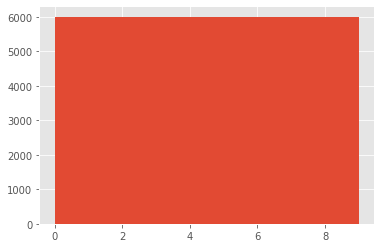

In [49]:
plt.hist(Y_train);

Vemos que el equilibrio es absoluto. 

Vamos a visualizar algunas imágenes para ver a lo que nos enfrentamos. Para ello seleccionamos una cualquiera de las filas (la 0, por ejemplo), la transformamos en un array y transformamos las dimensones a (28,28), que son las reales de estas imagenes. 

Hay que tener en cuenta que en el dataset viene con dimension (1,784), que hay que corregir para pasarlas a la red neuronal.

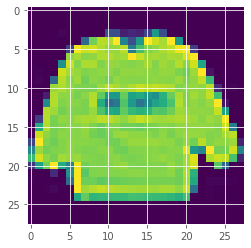

In [50]:
plt.imshow(np.array(x_train.iloc[0]).reshape((28,28)))

In [51]:
Y_train.iloc[0]

2

Según la documentación, el 2 es un pullover, lo que parece que cuadra.

Seguimos, haciendo primero una normalización de los datos y pasando la codificación de las variables independientes a one-hot

In [52]:
# Estandarizamos las imágenes y cambiamos la dimensión
x_train = np.array(x_train.astype("float") / 255.0)
x_test = np.array(x_test.astype("float") / 255.0)

In [53]:
x_train = x_train.reshape(len(x_train), 28, 28)
x_test = x_test.reshape(len(x_test), 28, 28)

In [54]:
x_train.shape

(60000, 28, 28)

Ahora pasamos a las etiquetas, cambiando su codificación y pasamos de tenerlas reflejadas como un entero de 0 a 9 (un valor para cada tipo de prenda), a un vector, lo que se conoce como One-hot encoding

In [55]:
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

In [56]:
Y_train[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

Vemos que ahora tenemos un array de numpy donde hay un 1 en el array con el índice correcto.

Por otro lado, vamos a documentar los nombres de las etiquetas, para mejor legibilidad cuando mostromos resultados:

In [57]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Dado que tendremos que jugar con muchos parámetros, es necesario crear un set de validación para no contaminar los datos de entrenamiento. Y dado que hay un equilibrio perfecto en el train set, usaremos cross-validation.train-test-split de sklearn.

In [58]:
x_train, x_val, Y_train, Y_val = train_test_split(x_train, Y_train, test_size=0.05, random_state=21, stratify=Y_train)

## Redes neuronales

Vamos a resolver en un primer paso este problema con redes neuronales convolucionales. Haremos varios experimentos para detectar los mejores parámetros, primero con una arquitectura de red sencilla (Lenet) y luego veremos otras un poco mas complejas.

In [22]:
opt = SGD(lr=0.01, momentum=0.9, nesterov=False)
model = LeNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

callbacks = [TrainingMonitor(figPath="./output/curva_exp01.png")]

/home/joselquin/anaconda3/envs/tf2/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


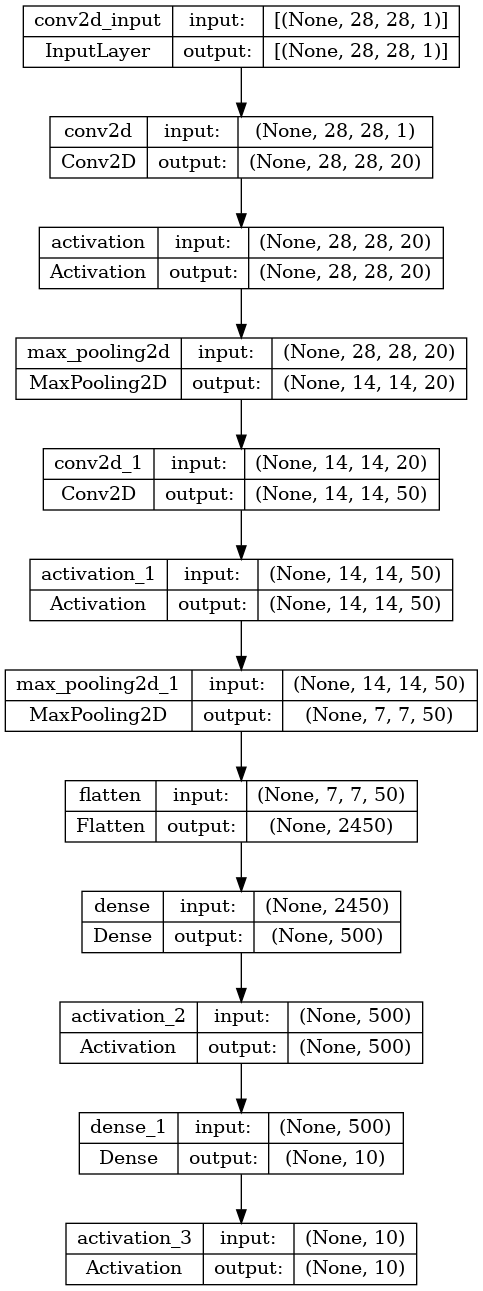

In [19]:
# Sacamos el grafo del modelo que acabamos de crear
plot_model(model, to_file="lenet.png", show_shapes=True)

In [21]:
print("[INFO] Entrenando la red. Experimento 1 ...")
model.fit(x_train, Y_train, validation_data=(x_va, Y_val), batch_size=64, epochs=100, callbacks=callbacks, verbose=1)

[INFO] Entrenando la red. Experimento 1 ...
Epoch 1/100
891/891 [==============================] - 26s 6ms/step - loss: 0.5514 - accuracy: 0.8020 - val_loss: 0.3834 - val_accuracy: 0.8627
Epoch 2/100
891/891 [==============================] - 5s 6ms/step - loss: 0.3440 - accuracy: 0.8753 - val_loss: 0.3311 - val_accuracy: 0.8780
Epoch 3/100
891/891 [==============================] - 5s 6ms/step - loss: 0.2924 - accuracy: 0.8931 - val_loss: 0.2963 - val_accuracy: 0.8900
Epoch 4/100
891/891 [==============================] - 5s 6ms/step - loss: 0.2615 - accuracy: 0.9034 - val_loss: 0.2619 - val_accuracy: 0.9020
Epoch 5/100
891/891 [==============================] - 5s 6ms/step - loss: 0.2343 - accuracy: 0.9145 - val_loss: 0.2714 - val_accuracy: 0.8997
Epoch 6/100
891/891 [==============================] - 5s 6ms/step - loss: 0.2188 - accuracy: 0.9184 - val_loss: 0.2513 - val_accuracy: 0.9047
Epoch 7/100
891/891 [==============================] - 5s 6ms/step - loss: 0.1966 - accuracy: 0.9

891/891 [==============================] - 5s 6ms/step - loss: 0.1379 - accuracy: 0.9496 - val_loss: 0.2526 - val_accuracy: 0.9160
Epoch 12/100
891/891 [==============================] - 5s 6ms/step - loss: 0.1240 - accuracy: 0.9534 - val_loss: 0.2561 - val_accuracy: 0.9130
Epoch 13/100
891/891 [==============================] - 5s 6ms/step - loss: 0.1113 - accuracy: 0.9588 - val_loss: 0.2561 - val_accuracy: 0.9207
Epoch 14/100
891/891 [==============================] - 5s 6ms/step - loss: 0.0990 - accuracy: 0.9640 - val_loss: 0.2626 - val_accuracy: 0.9187
Epoch 15/100
891/891 [==============================] - 5s 6ms/step - loss: 0.0871 - accuracy: 0.9683 - val_loss: 0.2764 - val_accuracy: 0.9130
Epoch 16/100
891/891 [==============================] - 5s 6ms/step - loss: 0.0774 - accuracy: 0.9716 - val_loss: 0.2705 - val_accuracy: 0.9247
Epoch 17/100
887/891 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9759{'loss': [0.5513651371002197, 0.34401652216911316, 0

891/891 [==============================] - 5s 6ms/step - loss: 0.0666 - accuracy: 0.9759 - val_loss: 0.3283 - val_accuracy: 0.9143
Epoch 18/100
891/891 [==============================] - 5s 6ms/step - loss: 0.0582 - accuracy: 0.9783 - val_loss: 0.3027 - val_accuracy: 0.9170
Epoch 19/100
685/891 [======================>.......] - ETA: 1s - loss: 0.0494 - accuracy: 0.9822

KeyboardInterrupt: 

Tras solo unos 18 epochs (incluso ya con 10), vemos que este modelo tiene ya un overfitting muy acusado, por lo que podemos detenerlo.

<img src="./output/curva_exp01.png">

Vamos a cambiar el optimizador por Adam.

In [26]:
# Experimento 2

opt = Adam(lr=0.01)
model = LeNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
callbacks = [TrainingMonitor(figPath="./output/curva_exp02.png")]
model.fit(x_train, Y_train, validation_data=(x_val, Y_val), batch_size=64, epochs=100, callbacks=callbacks, verbose=1)       

Epoch 1/100
891/891 [==============================] - 6s 6ms/step - loss: 0.4500 - accuracy: 0.8363 - val_loss: 0.3362 - val_accuracy: 0.8803
Epoch 2/100
891/891 [==============================] - 5s 6ms/step - loss: 0.3265 - accuracy: 0.8798 - val_loss: 0.3271 - val_accuracy: 0.8780
Epoch 3/100
891/891 [==============================] - 5s 6ms/step - loss: 0.3080 - accuracy: 0.8858 - val_loss: 0.3264 - val_accuracy: 0.8767
Epoch 4/100
891/891 [==============================] - 5s 6ms/step - loss: 0.2889 - accuracy: 0.8923 - val_loss: 0.3166 - val_accuracy: 0.8860
Epoch 5/100
891/891 [==============================] - 5s 6ms/step - loss: 0.2829 - accuracy: 0.8965 - val_loss: 0.3351 - val_accuracy: 0.8860
Epoch 6/100
891/891 [==============================] - 5s 6ms/step - loss: 0.2718 - accuracy: 0.8991 - val_loss: 0.3593 - val_accuracy: 0.8827
Epoch 7/100
891/891 [==============================] - 5s 6ms/step - loss: 0.2608 - accuracy: 0.9036 - val_loss: 0.3472 - val_accuracy: 0.8767

891/891 [==============================] - 5s 6ms/step - loss: 0.2359 - accuracy: 0.9133 - val_loss: 0.4035 - val_accuracy: 0.8820
Epoch 12/100
891/891 [==============================] - 5s 6ms/step - loss: 0.2426 - accuracy: 0.9119 - val_loss: 0.4382 - val_accuracy: 0.8780
Epoch 13/100
891/891 [==============================] - 5s 6ms/step - loss: 0.2307 - accuracy: 0.9147 - val_loss: 0.4782 - val_accuracy: 0.8783
Epoch 14/100
  1/891 [..............................] - ETA: 7s - loss: 0.2428 - accuracy: 0.9062

KeyboardInterrupt: 

¡Incluso peor!

<img src="./output/curva_exp02.png">

Vamos a utilizar una arquitectura diferente, la MiniVGGNet, donde tenemos una mayor regularización (podría readaptarse la clase de LeNet para meter una regularización L2, así como Dropout, pero lo intentaremos antes con MiniVGGNet).

/home/joselquin/anaconda3/envs/tf2/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


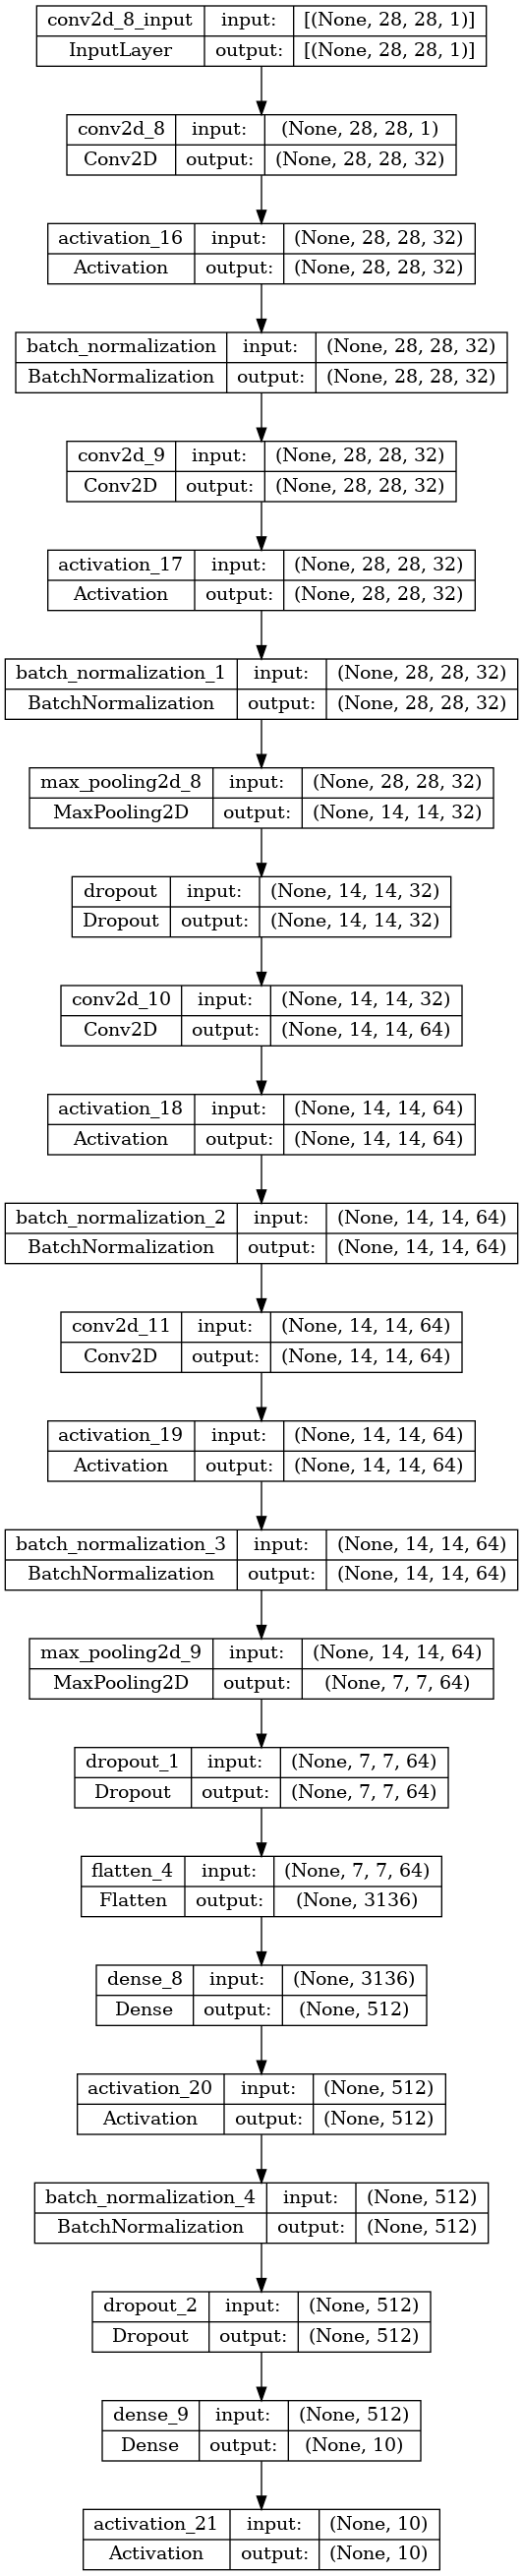

In [28]:
# Experimento 3

opt = SGD(lr=0.01, momentum=0.9, nesterov=False)
model = MiniVGGNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

callbacks = [TrainingMonitor(figPath="./output/curva_exp03.png")]
# Sacamos el grafo del modelo que acabamos de crear
plot_model(model, to_file="minivggnet.png", show_shapes=True)

In [29]:
model.fit(x_train, Y_train, validation_data=(x_val, Y_val), batch_size=64, epochs=100, callbacks=callbacks, verbose=1)      

Epoch 1/100
891/891 [==============================] - 13s 13ms/step - loss: 0.5288 - accuracy: 0.8174 - val_loss: 0.3189 - val_accuracy: 0.8873
Epoch 2/100
891/891 [==============================] - 11s 12ms/step - loss: 0.3533 - accuracy: 0.8746 - val_loss: 0.2703 - val_accuracy: 0.9040
Epoch 3/100
891/891 [==============================] - 11s 12ms/step - loss: 0.3009 - accuracy: 0.8917 - val_loss: 0.2406 - val_accuracy: 0.9147
Epoch 4/100
891/891 [==============================] - 11s 12ms/step - loss: 0.2764 - accuracy: 0.9005 - val_loss: 0.2370 - val_accuracy: 0.9173
Epoch 5/100
891/891 [==============================] - 11s 12ms/step - loss: 0.2593 - accuracy: 0.9069 - val_loss: 0.2301 - val_accuracy: 0.9187
Epoch 6/100
891/891 [==============================] - 11s 12ms/step - loss: 0.2428 - accuracy: 0.9123 - val_loss: 0.2318 - val_accuracy: 0.9200
Epoch 7/100
891/891 [==============================] - 11s 12ms/step - loss: 0.2292 - accuracy: 0.9168 - val_loss: 0.2080 - val_ac

Epoch 12/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1857 - accuracy: 0.9328 - val_loss: 0.2016 - val_accuracy: 0.9293
Epoch 13/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1811 - accuracy: 0.9344 - val_loss: 0.2081 - val_accuracy: 0.9213
Epoch 14/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1742 - accuracy: 0.9357 - val_loss: 0.2050 - val_accuracy: 0.9287
Epoch 15/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1676 - accuracy: 0.9375 - val_loss: 0.2139 - val_accuracy: 0.9280
Epoch 16/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1663 - accuracy: 0.9385 - val_loss: 0.1953 - val_accuracy: 0.9337
Epoch 17/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1558 - accuracy: 0.9426 - val_loss: 0.1971 - val_accuracy: 0.9317


Epoch 18/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1521 - accuracy: 0.9442 - val_loss: 0.1860 - val_accuracy: 0.9320
Epoch 19/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1487 - accuracy: 0.9453 - val_loss: 0.1966 - val_accuracy: 0.9337
Epoch 20/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1457 - accuracy: 0.9461 - val_loss: 0.2004 - val_accuracy: 0.9353
Epoch 21/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1411 - accuracy: 0.9470 - val_loss: 0.1941 - val_accuracy: 0.9360
Epoch 22/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1373 - accuracy: 0.9488 - val_loss: 0.1868 - val_accuracy: 0.9400


Epoch 23/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1310 - accuracy: 0.9504 - val_loss: 0.1862 - val_accuracy: 0.9413
Epoch 24/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1289 - accuracy: 0.9534 - val_loss: 0.1985 - val_accuracy: 0.9353
Epoch 25/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1246 - accuracy: 0.9537 - val_loss: 0.1983 - val_accuracy: 0.9350
Epoch 26/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1225 - accuracy: 0.9547 - val_loss: 0.1937 - val_accuracy: 0.9377


Epoch 27/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1160 - accuracy: 0.9563 - val_loss: 0.1908 - val_accuracy: 0.9437
Epoch 28/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1123 - accuracy: 0.9589 - val_loss: 0.3160 - val_accuracy: 0.9177
Epoch 29/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1099 - accuracy: 0.9596 - val_loss: 0.1897 - val_accuracy: 0.9410
Epoch 30/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1101 - accuracy: 0.9589 - val_loss: 0.1994 - val_accuracy: 0.9393


Epoch 31/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1024 - accuracy: 0.9620 - val_loss: 0.1960 - val_accuracy: 0.9367
Epoch 32/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1062 - accuracy: 0.9604 - val_loss: 0.2016 - val_accuracy: 0.9357
Epoch 33/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0999 - accuracy: 0.9634 - val_loss: 0.2146 - val_accuracy: 0.9367


Epoch 34/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0991 - accuracy: 0.9631 - val_loss: 0.1976 - val_accuracy: 0.9400
Epoch 35/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0956 - accuracy: 0.9648 - val_loss: 0.2207 - val_accuracy: 0.9397
Epoch 36/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0953 - accuracy: 0.9646 - val_loss: 0.1994 - val_accuracy: 0.9397


Epoch 37/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0895 - accuracy: 0.9672 - val_loss: 0.2067 - val_accuracy: 0.9387
Epoch 38/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0853 - accuracy: 0.9676 - val_loss: 0.2082 - val_accuracy: 0.9393
Epoch 39/100
776/891 [=========================>....] - ETA: 1s - loss: 0.0837 - accuracy: 0.9683

KeyboardInterrupt: 

Esto ya es otra cosa, con un modelo que promete, aunque tenemos que jugar con el learning rate y, posiblemente tmbién poner mayor regularización.

<img src="./output/curva_exp03.png">

In [30]:
# Experimento 4

opt = SGD(lr=0.001, momentum=0.9, nesterov=False)
model = MiniVGGNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
callbacks = [TrainingMonitor(figPath="./output/curva_exp04.png")]
model.fit(x_train, Y_train, validation_data=(x_val, Y_val), batch_size=64, epochs=100, callbacks=callbacks, verbose=1)   

/home/joselquin/anaconda3/envs/tf2/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
891/891 [==============================] - 12s 12ms/step - loss: 0.6624 - accuracy: 0.7774 - val_loss: 0.3433 - val_accuracy: 0.8757
Epoch 2/100
891/891 [==============================] - 10s 12ms/step - loss: 0.4275 - accuracy: 0.8497 - val_loss: 0.2911 - val_accuracy: 0.8927
Epoch 3/100
891/891 [==============================] - 11s 12ms/step - loss: 0.3707 - accuracy: 0.8675 - val_loss: 0.2787 - val_accuracy: 0.8960
Epoch 4/100
891/891 [==============================] - 10s 12ms/step - loss: 0.3379 - accuracy: 0.8781 - val_loss: 0.2616 - val_accuracy: 0.9020
Epoch 5/100
891/891 [==============================] - 10s 12ms/step - loss: 0.3145 - accuracy: 0.8853 - val_loss: 0.2591 - val_accuracy: 0.9040
Epoch 6/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2993 - accuracy: 0.8913 - val_loss: 0.2346 - val_accuracy: 0.9160
Epoch 7/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2874 - accuracy: 0.8960 - val_loss: 0.2375 - val_ac

Epoch 12/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2442 - accuracy: 0.9100 - val_loss: 0.2261 - val_accuracy: 0.9177
Epoch 13/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2374 - accuracy: 0.9143 - val_loss: 0.2165 - val_accuracy: 0.9253
Epoch 14/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2318 - accuracy: 0.9155 - val_loss: 0.2233 - val_accuracy: 0.9183
Epoch 15/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2292 - accuracy: 0.9162 - val_loss: 0.2286 - val_accuracy: 0.9187
Epoch 16/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2241 - accuracy: 0.9167 - val_loss: 0.2172 - val_accuracy: 0.9210
Epoch 17/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2216 - accuracy: 0.9190 - val_loss: 0.2021 - val_accuracy: 0.9257


Epoch 18/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2150 - accuracy: 0.9222 - val_loss: 0.1958 - val_accuracy: 0.9310
Epoch 19/100
891/891 [==============================] - 11s 12ms/step - loss: 0.2117 - accuracy: 0.9231 - val_loss: 0.2032 - val_accuracy: 0.9257
Epoch 20/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2087 - accuracy: 0.9240 - val_loss: 0.2065 - val_accuracy: 0.9253
Epoch 21/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2054 - accuracy: 0.9243 - val_loss: 0.2014 - val_accuracy: 0.9267
Epoch 22/100
891/891 [==============================] - 10s 12ms/step - loss: 0.2014 - accuracy: 0.9259 - val_loss: 0.1890 - val_accuracy: 0.9317


Epoch 23/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1984 - accuracy: 0.9270 - val_loss: 0.1925 - val_accuracy: 0.9317
Epoch 24/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1955 - accuracy: 0.9294 - val_loss: 0.1986 - val_accuracy: 0.9287
Epoch 25/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1952 - accuracy: 0.9277 - val_loss: 0.1896 - val_accuracy: 0.9310
Epoch 26/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1892 - accuracy: 0.9308 - val_loss: 0.2064 - val_accuracy: 0.9253


Epoch 27/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1874 - accuracy: 0.9306 - val_loss: 0.1896 - val_accuracy: 0.9307
Epoch 28/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1812 - accuracy: 0.9331 - val_loss: 0.2179 - val_accuracy: 0.9213
Epoch 29/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1826 - accuracy: 0.9324 - val_loss: 0.1844 - val_accuracy: 0.9340
Epoch 30/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1808 - accuracy: 0.9340 - val_loss: 0.1885 - val_accuracy: 0.9327


Epoch 31/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1763 - accuracy: 0.9351 - val_loss: 0.1903 - val_accuracy: 0.9310
Epoch 32/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1756 - accuracy: 0.9357 - val_loss: 0.1854 - val_accuracy: 0.9350
Epoch 33/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1752 - accuracy: 0.9344 - val_loss: 0.1922 - val_accuracy: 0.9327


Epoch 34/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1699 - accuracy: 0.9369 - val_loss: 0.1912 - val_accuracy: 0.9323
Epoch 35/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1701 - accuracy: 0.9371 - val_loss: 0.1842 - val_accuracy: 0.9363
Epoch 36/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1673 - accuracy: 0.9375 - val_loss: 0.1936 - val_accuracy: 0.9337


Epoch 37/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1667 - accuracy: 0.9391 - val_loss: 0.1803 - val_accuracy: 0.9360
Epoch 38/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1612 - accuracy: 0.9401 - val_loss: 0.1797 - val_accuracy: 0.9370
Epoch 39/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1602 - accuracy: 0.9404 - val_loss: 0.1791 - val_accuracy: 0.9367


Epoch 40/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1584 - accuracy: 0.9417 - val_loss: 0.1817 - val_accuracy: 0.9370
Epoch 41/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1588 - accuracy: 0.9408 - val_loss: 0.1800 - val_accuracy: 0.9370
Epoch 42/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1556 - accuracy: 0.9421 - val_loss: 0.1816 - val_accuracy: 0.9353


Epoch 43/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1528 - accuracy: 0.9429 - val_loss: 0.1894 - val_accuracy: 0.9317
Epoch 44/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1526 - accuracy: 0.9432 - val_loss: 0.1799 - val_accuracy: 0.9327
Epoch 45/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1527 - accuracy: 0.9431 - val_loss: 0.1768 - val_accuracy: 0.9400


Epoch 46/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1499 - accuracy: 0.9444 - val_loss: 0.1781 - val_accuracy: 0.9370
Epoch 47/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1490 - accuracy: 0.9445 - val_loss: 0.1825 - val_accuracy: 0.9377
Epoch 48/100


891/891 [==============================] - 11s 12ms/step - loss: 0.1444 - accuracy: 0.9454 - val_loss: 0.1768 - val_accuracy: 0.9370
Epoch 49/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1451 - accuracy: 0.9464 - val_loss: 0.1811 - val_accuracy: 0.9393


Epoch 50/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1433 - accuracy: 0.9468 - val_loss: 0.1731 - val_accuracy: 0.9377
Epoch 51/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1388 - accuracy: 0.9489 - val_loss: 0.1796 - val_accuracy: 0.9377


Epoch 52/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1399 - accuracy: 0.9487 - val_loss: 0.1811 - val_accuracy: 0.9390
Epoch 53/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1383 - accuracy: 0.9481 - val_loss: 0.1730 - val_accuracy: 0.9390


Epoch 54/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1333 - accuracy: 0.9512 - val_loss: 0.1720 - val_accuracy: 0.9383
Epoch 55/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1332 - accuracy: 0.9509 - val_loss: 0.1738 - val_accuracy: 0.9390


Epoch 56/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1358 - accuracy: 0.9503 - val_loss: 0.1784 - val_accuracy: 0.9387
Epoch 57/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1321 - accuracy: 0.9511 - val_loss: 0.1798 - val_accuracy: 0.9363


Epoch 58/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1304 - accuracy: 0.9517 - val_loss: 0.1955 - val_accuracy: 0.9330
Epoch 59/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1269 - accuracy: 0.9534 - val_loss: 0.1737 - val_accuracy: 0.9400


Epoch 60/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1261 - accuracy: 0.9539 - val_loss: 0.1893 - val_accuracy: 0.9390
Epoch 61/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1261 - accuracy: 0.9531 - val_loss: 0.1745 - val_accuracy: 0.9377


Epoch 62/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1231 - accuracy: 0.9538 - val_loss: 0.1743 - val_accuracy: 0.9397
Epoch 63/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1237 - accuracy: 0.9543 - val_loss: 0.1739 - val_accuracy: 0.9400


Epoch 64/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1207 - accuracy: 0.9551 - val_loss: 0.1778 - val_accuracy: 0.9363
Epoch 65/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1216 - accuracy: 0.9553 - val_loss: 0.1742 - val_accuracy: 0.9397


Epoch 66/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1176 - accuracy: 0.9570 - val_loss: 0.2082 - val_accuracy: 0.9310
Epoch 67/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1162 - accuracy: 0.9567 - val_loss: 0.1732 - val_accuracy: 0.9393


Epoch 68/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1168 - accuracy: 0.9566 - val_loss: 0.1805 - val_accuracy: 0.9397
Epoch 69/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1174 - accuracy: 0.9559 - val_loss: 0.1790 - val_accuracy: 0.9380


Epoch 70/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1132 - accuracy: 0.9586 - val_loss: 0.1793 - val_accuracy: 0.9380
Epoch 71/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1103 - accuracy: 0.9580 - val_loss: 0.1717 - val_accuracy: 0.9433


Epoch 72/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1117 - accuracy: 0.9576 - val_loss: 0.1784 - val_accuracy: 0.9417
Epoch 73/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1072 - accuracy: 0.9610 - val_loss: 0.1794 - val_accuracy: 0.9367


Epoch 74/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1107 - accuracy: 0.9591 - val_loss: 0.1743 - val_accuracy: 0.9397
Epoch 75/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1061 - accuracy: 0.9604 - val_loss: 0.1786 - val_accuracy: 0.9390


Epoch 76/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1063 - accuracy: 0.9596 - val_loss: 0.1819 - val_accuracy: 0.9383
Epoch 77/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1064 - accuracy: 0.9599 - val_loss: 0.1747 - val_accuracy: 0.9403


Epoch 78/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1049 - accuracy: 0.9613 - val_loss: 0.1833 - val_accuracy: 0.9417
Epoch 79/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1042 - accuracy: 0.9612 - val_loss: 0.1762 - val_accuracy: 0.9407


Epoch 80/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1042 - accuracy: 0.9609 - val_loss: 0.1705 - val_accuracy: 0.9427
Epoch 81/100
891/891 [==============================] - 10s 12ms/step - loss: 0.1016 - accuracy: 0.9627 - val_loss: 0.1911 - val_accuracy: 0.9370


Epoch 82/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0986 - accuracy: 0.9633 - val_loss: 0.1811 - val_accuracy: 0.9400
Epoch 83/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0992 - accuracy: 0.9636 - val_loss: 0.1994 - val_accuracy: 0.9383


Epoch 84/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0992 - accuracy: 0.9630 - val_loss: 0.1799 - val_accuracy: 0.9397
Epoch 85/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0987 - accuracy: 0.9631 - val_loss: 0.1987 - val_accuracy: 0.9343


Epoch 86/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0957 - accuracy: 0.9638 - val_loss: 0.1840 - val_accuracy: 0.9410
Epoch 87/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0948 - accuracy: 0.9648 - val_loss: 0.1791 - val_accuracy: 0.9423


Epoch 88/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0951 - accuracy: 0.9647 - val_loss: 0.1841 - val_accuracy: 0.9413
Epoch 89/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0959 - accuracy: 0.9642 - val_loss: 0.1786 - val_accuracy: 0.9403


Epoch 90/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0905 - accuracy: 0.9660 - val_loss: 0.1858 - val_accuracy: 0.9393
Epoch 91/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0921 - accuracy: 0.9656 - val_loss: 0.1808 - val_accuracy: 0.9457


Epoch 92/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0901 - accuracy: 0.9662 - val_loss: 0.1841 - val_accuracy: 0.9410
Epoch 93/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0888 - accuracy: 0.9663 - val_loss: 0.1770 - val_accuracy: 0.9453


Epoch 94/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0882 - accuracy: 0.9670 - val_loss: 0.1794 - val_accuracy: 0.9427
Epoch 95/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0875 - accuracy: 0.9675 - val_loss: 0.1827 - val_accuracy: 0.9403


Epoch 96/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0843 - accuracy: 0.9683 - val_loss: 0.1814 - val_accuracy: 0.9443
Epoch 97/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0882 - accuracy: 0.9673 - val_loss: 0.1862 - val_accuracy: 0.9417


Epoch 98/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0873 - accuracy: 0.9677 - val_loss: 0.1782 - val_accuracy: 0.9407


Epoch 99/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0827 - accuracy: 0.9692 - val_loss: 0.1811 - val_accuracy: 0.9423


Epoch 100/100
891/891 [==============================] - 10s 12ms/step - loss: 0.0846 - accuracy: 0.9684 - val_loss: 0.1864 - val_accuracy: 0.9417


Interesantes resultados.Posiblemente deberíamos haber cortado sobre el epoch 40, donde podemos decir que el val_loss ya no mejora y empieza el overfitting. Caundo yatengamos el modelo decidido, integraremos el set de validación en el de entrenamiento y pondremos un early stopping.

<img src="./output/curva_exp04.png">

Aún con esto, tendríamos estos resultados:

In [34]:
predictions = model.predict(x_val, batch_size=64)
print(classification_report(Y_val.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labels))

[INFO] evaluating network...
47/47 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.90      0.88      0.89       300
     Trouser       0.99      0.99      0.99       300
    Pullover       0.95      0.93      0.94       300
       Dress       0.96      0.93      0.94       300
        Coat       0.89      0.93      0.91       300
      Sandal       0.99      0.98      0.99       300
       Shirt       0.80      0.82      0.81       300
     Sneaker       0.98      0.99      0.98       300
         Bag       0.99      0.98      0.99       300
  Ankle boot       0.98      0.98      0.98       300

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



En el experimento 5 vamos a cambiar GSD por Adam y vamos a incorporar Early Stopping

In [37]:
# Experimento 5

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
opt = Adam(lr=0.001)
model = MiniVGGNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
tm = TrainingMonitor(figPath="./output/curva_exp05.png")
model.fit(x_train, Y_train, validation_data=(x_val, Y_val), batch_size=64, epochs=100, callbacks=[es, tm], verbose=1)


/home/joselquin/anaconda3/envs/tf2/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
891/891 [==============================] - 12s 12ms/step - loss: 0.4545 - accuracy: 0.8430 - val_loss: 0.2818 - val_accuracy: 0.9000
Epoch 2/100
891/891 [==============================] - 11s 13ms/step - loss: 0.2936 - accuracy: 0.8937 - val_loss: 0.2290 - val_accuracy: 0.9170
Epoch 3/100
891/891 [==============================] - 11s 12ms/step - loss: 0.2617 - accuracy: 0.9052 - val_loss: 0.2382 - val_accuracy: 0.9050
Epoch 4/100
891/891 [==============================] - 11s 12ms/step - loss: 0.2391 - accuracy: 0.9129 - val_loss: 0.2129 - val_accuracy: 0.9233
Epoch 5/100
891/891 [==============================] - 11s 12ms/step - loss: 0.2227 - accuracy: 0.9190 - val_loss: 0.2167 - val_accuracy: 0.9210
Epoch 6/100
891/891 [==============================] - 11s 12ms/step - loss: 0.2072 - accuracy: 0.9248 - val_loss: 0.1943 - val_accuracy: 0.9313
Epoch 7/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1970 - accuracy: 0.9286 - val_loss: 0.2179 - val_ac

Epoch 12/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1590 - accuracy: 0.9417 - val_loss: 0.1732 - val_accuracy: 0.9377
Epoch 13/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1383 - accuracy: 0.9490 - val_loss: 0.1828 - val_accuracy: 0.9383
Epoch 14/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1363 - accuracy: 0.9496 - val_loss: 0.1950 - val_accuracy: 0.9333
Epoch 15/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1267 - accuracy: 0.9527 - val_loss: 0.1963 - val_accuracy: 0.9360
Epoch 16/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1185 - accuracy: 0.9552 - val_loss: 0.1744 - val_accuracy: 0.9393
Epoch 17/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1147 - accuracy: 0.9576 - val_loss: 0.1952 - val_accuracy: 0.9400


Epoch 18/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1106 - accuracy: 0.9586 - val_loss: 0.1798 - val_accuracy: 0.9390
Epoch 19/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1051 - accuracy: 0.9612 - val_loss: 0.1784 - val_accuracy: 0.9427
Epoch 20/100
891/891 [==============================] - 11s 12ms/step - loss: 0.1018 - accuracy: 0.9626 - val_loss: 0.2042 - val_accuracy: 0.9373
Epoch 21/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0979 - accuracy: 0.9637 - val_loss: 0.1940 - val_accuracy: 0.9423
Epoch 22/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0911 - accuracy: 0.9660 - val_loss: 0.1962 - val_accuracy: 0.9440


Epoch 23/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0841 - accuracy: 0.9696 - val_loss: 0.2166 - val_accuracy: 0.9380
Epoch 24/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0848 - accuracy: 0.9686 - val_loss: 0.2105 - val_accuracy: 0.9390
Epoch 25/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0844 - accuracy: 0.9695 - val_loss: 0.2085 - val_accuracy: 0.9387
Epoch 26/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0805 - accuracy: 0.9699 - val_loss: 0.1872 - val_accuracy: 0.9473


Epoch 27/100
891/891 [==============================] - 11s 12ms/step - loss: 0.0771 - accuracy: 0.9714 - val_loss: 0.2008 - val_accuracy: 0.9410
Epoch 27: early stopping


Parece que converge antes que con GSD, aunque con más irregularidad del val_loss. Se llega al mismo resultado.

<img src="./output/curva_exp05.png">

In [38]:
predictions = model.predict(x_val, batch_size=64)
print(classification_report(Y_val.argmax(axis=1), predictions.argmax(axis=1), target_names=labels))

47/47 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.90      0.89       300
     Trouser       0.99      0.99      0.99       300
    Pullover       0.96      0.91      0.94       300
       Dress       0.97      0.93      0.95       300
        Coat       0.87      0.96      0.91       300
      Sandal       1.00      0.99      0.99       300
       Shirt       0.83      0.79      0.81       300
     Sneaker       0.96      0.98      0.97       300
         Bag       0.98      0.98      0.98       300
  Ankle boot       0.98      0.97      0.98       300

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



Puede que afinando el learning rate y la regularización pudiéramos sacar algo más, pero de momento lo dejaremos aquí, a la espera de usar modelos ensamblados en una segunda parte de este ejercicio.

Ahora, terminaremos aquí uniendo de nuevo los sets de validación y entrenamisnto y evaluando definitivamente la red con el set de test.

In [ ]:
# Resultado final

x_train = np.concatenate((x_train, x_val), axis=0)
Y_train = np.concatenate((Y_train, Y_val), axis=0)

In [60]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
opt = Adam(lr=0.001)
model = MiniVGGNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
tm = TrainingMonitor(figPath="./output/curva_exp06.png")
model.fit(x_train, Y_train, validation_data=(x_test, Y_test), batch_size=64, epochs=100, callbacks=[es, tm], verbose=1)

predictions = model.predict(x_test, batch_size=64)
print(classification_report(Y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labels))

Epoch 1/100
938/938 [==============================] - 13s 13ms/step - loss: 0.4559 - accuracy: 0.8418 - val_loss: 0.2648 - val_accuracy: 0.9043
Epoch 2/100
938/938 [==============================] - 12s 13ms/step - loss: 0.2968 - accuracy: 0.8924 - val_loss: 0.2575 - val_accuracy: 0.9057
Epoch 3/100
938/938 [==============================] - 12s 13ms/step - loss: 0.2614 - accuracy: 0.9061 - val_loss: 0.2224 - val_accuracy: 0.9219
Epoch 4/100
938/938 [==============================] - 12s 13ms/step - loss: 0.2371 - accuracy: 0.9141 - val_loss: 0.2093 - val_accuracy: 0.9236
Epoch 5/100
938/938 [==============================] - 12s 13ms/step - loss: 0.2189 - accuracy: 0.9204 - val_loss: 0.2567 - val_accuracy: 0.9188
Epoch 6/100
938/938 [==============================] - 12s 13ms/step - loss: 0.2067 - accuracy: 0.9249 - val_loss: 0.1827 - val_accuracy: 0.9339
Epoch 7/100
938/938 [==============================] - 12s 13ms/step - loss: 0.1942 - accuracy: 0.9290 - val_loss: 0.1819 - val_ac

Epoch 12/100
938/938 [==============================] - 12s 13ms/step - loss: 0.1444 - accuracy: 0.9468 - val_loss: 0.1792 - val_accuracy: 0.9385
Epoch 13/100
938/938 [==============================] - 12s 13ms/step - loss: 0.1422 - accuracy: 0.9471 - val_loss: 0.1808 - val_accuracy: 0.9361
Epoch 14/100
938/938 [==============================] - 12s 13ms/step - loss: 0.1336 - accuracy: 0.9509 - val_loss: 0.1652 - val_accuracy: 0.9425
Epoch 15/100
938/938 [==============================] - 12s 13ms/step - loss: 0.1229 - accuracy: 0.9539 - val_loss: 0.1760 - val_accuracy: 0.9415
Epoch 16/100
938/938 [==============================] - 12s 13ms/step - loss: 0.1171 - accuracy: 0.9568 - val_loss: 0.1762 - val_accuracy: 0.9411
Epoch 17/100
938/938 [==============================] - 12s 13ms/step - loss: 0.1136 - accuracy: 0.9583 - val_loss: 0.1687 - val_accuracy: 0.9421


Epoch 18/100
938/938 [==============================] - 12s 13ms/step - loss: 0.1082 - accuracy: 0.9601 - val_loss: 0.1805 - val_accuracy: 0.9386
Epoch 19/100
938/938 [==============================] - 12s 13ms/step - loss: 0.1071 - accuracy: 0.9605 - val_loss: 0.1847 - val_accuracy: 0.9394
Epoch 20/100
938/938 [==============================] - 12s 13ms/step - loss: 0.0991 - accuracy: 0.9633 - val_loss: 0.1772 - val_accuracy: 0.9426
Epoch 21/100
938/938 [==============================] - 12s 13ms/step - loss: 0.0918 - accuracy: 0.9658 - val_loss: 0.1825 - val_accuracy: 0.9413
Epoch 22/100
938/938 [==============================] - 12s 13ms/step - loss: 0.0917 - accuracy: 0.9660 - val_loss: 0.1738 - val_accuracy: 0.9451


Epoch 23/100
938/938 [==============================] - 12s 13ms/step - loss: 0.0851 - accuracy: 0.9686 - val_loss: 0.1855 - val_accuracy: 0.9409
Epoch 24/100
938/938 [==============================] - 12s 13ms/step - loss: 0.0842 - accuracy: 0.9686 - val_loss: 0.1891 - val_accuracy: 0.9421
Epoch 25/100
938/938 [==============================] - 12s 13ms/step - loss: 0.0821 - accuracy: 0.9700 - val_loss: 0.1912 - val_accuracy: 0.9423
Epoch 26/100
938/938 [==============================] - 12s 13ms/step - loss: 0.0793 - accuracy: 0.9704 - val_loss: 0.1964 - val_accuracy: 0.9434


Epoch 27/100
938/938 [==============================] - 12s 13ms/step - loss: 0.0754 - accuracy: 0.9726 - val_loss: 0.1941 - val_accuracy: 0.9424
Epoch 28/100
938/938 [==============================] - 12s 13ms/step - loss: 0.0709 - accuracy: 0.9737 - val_loss: 0.1909 - val_accuracy: 0.9460
Epoch 29/100
938/938 [==============================] - 12s 13ms/step - loss: 0.0705 - accuracy: 0.9745 - val_loss: 0.1954 - val_accuracy: 0.9445
Epoch 29: early stopping
157/157 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.91      0.90      1000
     Trouser       0.99      1.00      0.99      1000
    Pullover       0.93      0.91      0.92      1000
       Dress       0.94      0.96      0.95      1000
        Coat       0.90      0.94      0.92      1000
      Sandal       1.00      0.98      0.99      1000
       Shirt       0.86      0.81      0.83      1000
     Sneaker       0.97      0.96      0.97      

<img src="./output/curva_exp06.png">